# The versatility of RNA-Seq as seen through an analysis of hepatic transcriptomes from patients with NAFLD and NASH

<b>MED 263 </b>- Final Project, Group #3

Tutorial inspired by: Dr. Fish (RNA-seq) and Dr. Tamayo (GSEA analysis)

Tutorial adapted by: Ethan Badger; Jose Sandoval; Karla Godinez-Macias.

<b>Overview</b>

In this tutorial, we will be analyzing non-alcoholic fatty liver samples from an RNA-seq study (GSE126848 dataset). We will illustrate how this data can be used to better understand the transcriptome dynamics in overweight and obese patients.

## Non-alcoholic Fatty Liver Disease

Nonalcoholic fatty liver disease (NAFLD) is a condition in which excessive fat is stored in the liver [1]. It is the most common cause of liver disease in the United States [2] and has recently been associated with increased risk for developing diabetes and coronary artery disease [3]. Certain health conditions, including obesity, may increase the risk of developing NAFLD, or its subtype, non-alcoholic steatohepatitis (NASH). Though these are increasingly impacting our population, little is understood about the development of NAFLD and its transition into NASH.

In this workshop, we will analyze hepatic transcriptome signatures in patients with varying degrees of non-alcoholic fatty liver disease compared to healthy normal individuals in order to identify their expression patterns and similarities, and biomolecular mechanisms that may cause transitions between these states.

The analysis will be conducted using the [GSE126848](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126848) dataset. We will pre-process raw reads and provide a read count table for downstream analysis. Throughout this tutorial, we will 1) illustrate pre-processing data workflows including quality control checks, genome alignments and generate read count tables, 2) Give hands-on experience on DESeq2 to analyze the table, normalize and calculate gene differential expression, and lastly 3) Interpret and use fold changes for enrichment and pathway analyses.

## Getting started

In this study ([GSE126848](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126848)) RNA sequencing and quantitative histomorphometry of liver fat, inflammation and fibrosis was performed on liver biopsies obtained from a cohort of healthy normal (n=X) and obese patients (n=X).

In this section we will illustrate how one can process raw sequencing data, starting from FastQs obtained with Illumina 2500 technology. We will not execute the commands during the session due to time constrains, but will provide an example for reference.

## Processing Raw Data

Processing raw RNA-sequencing data is the first step to analyze gene expression patterns and contrast two or more conditions. The steps followed are indicated in Figure 1 along with packages used in this tutorial. 

These steps include quality, alignment with STAR to the reference genome (Human hg38), generation of read count tables using RSEM and calculating differential expression with DESeq2. After calculating gene expression for the desired conditions, we can continuew downstream analysis and observe(?) interesting biology of the results.

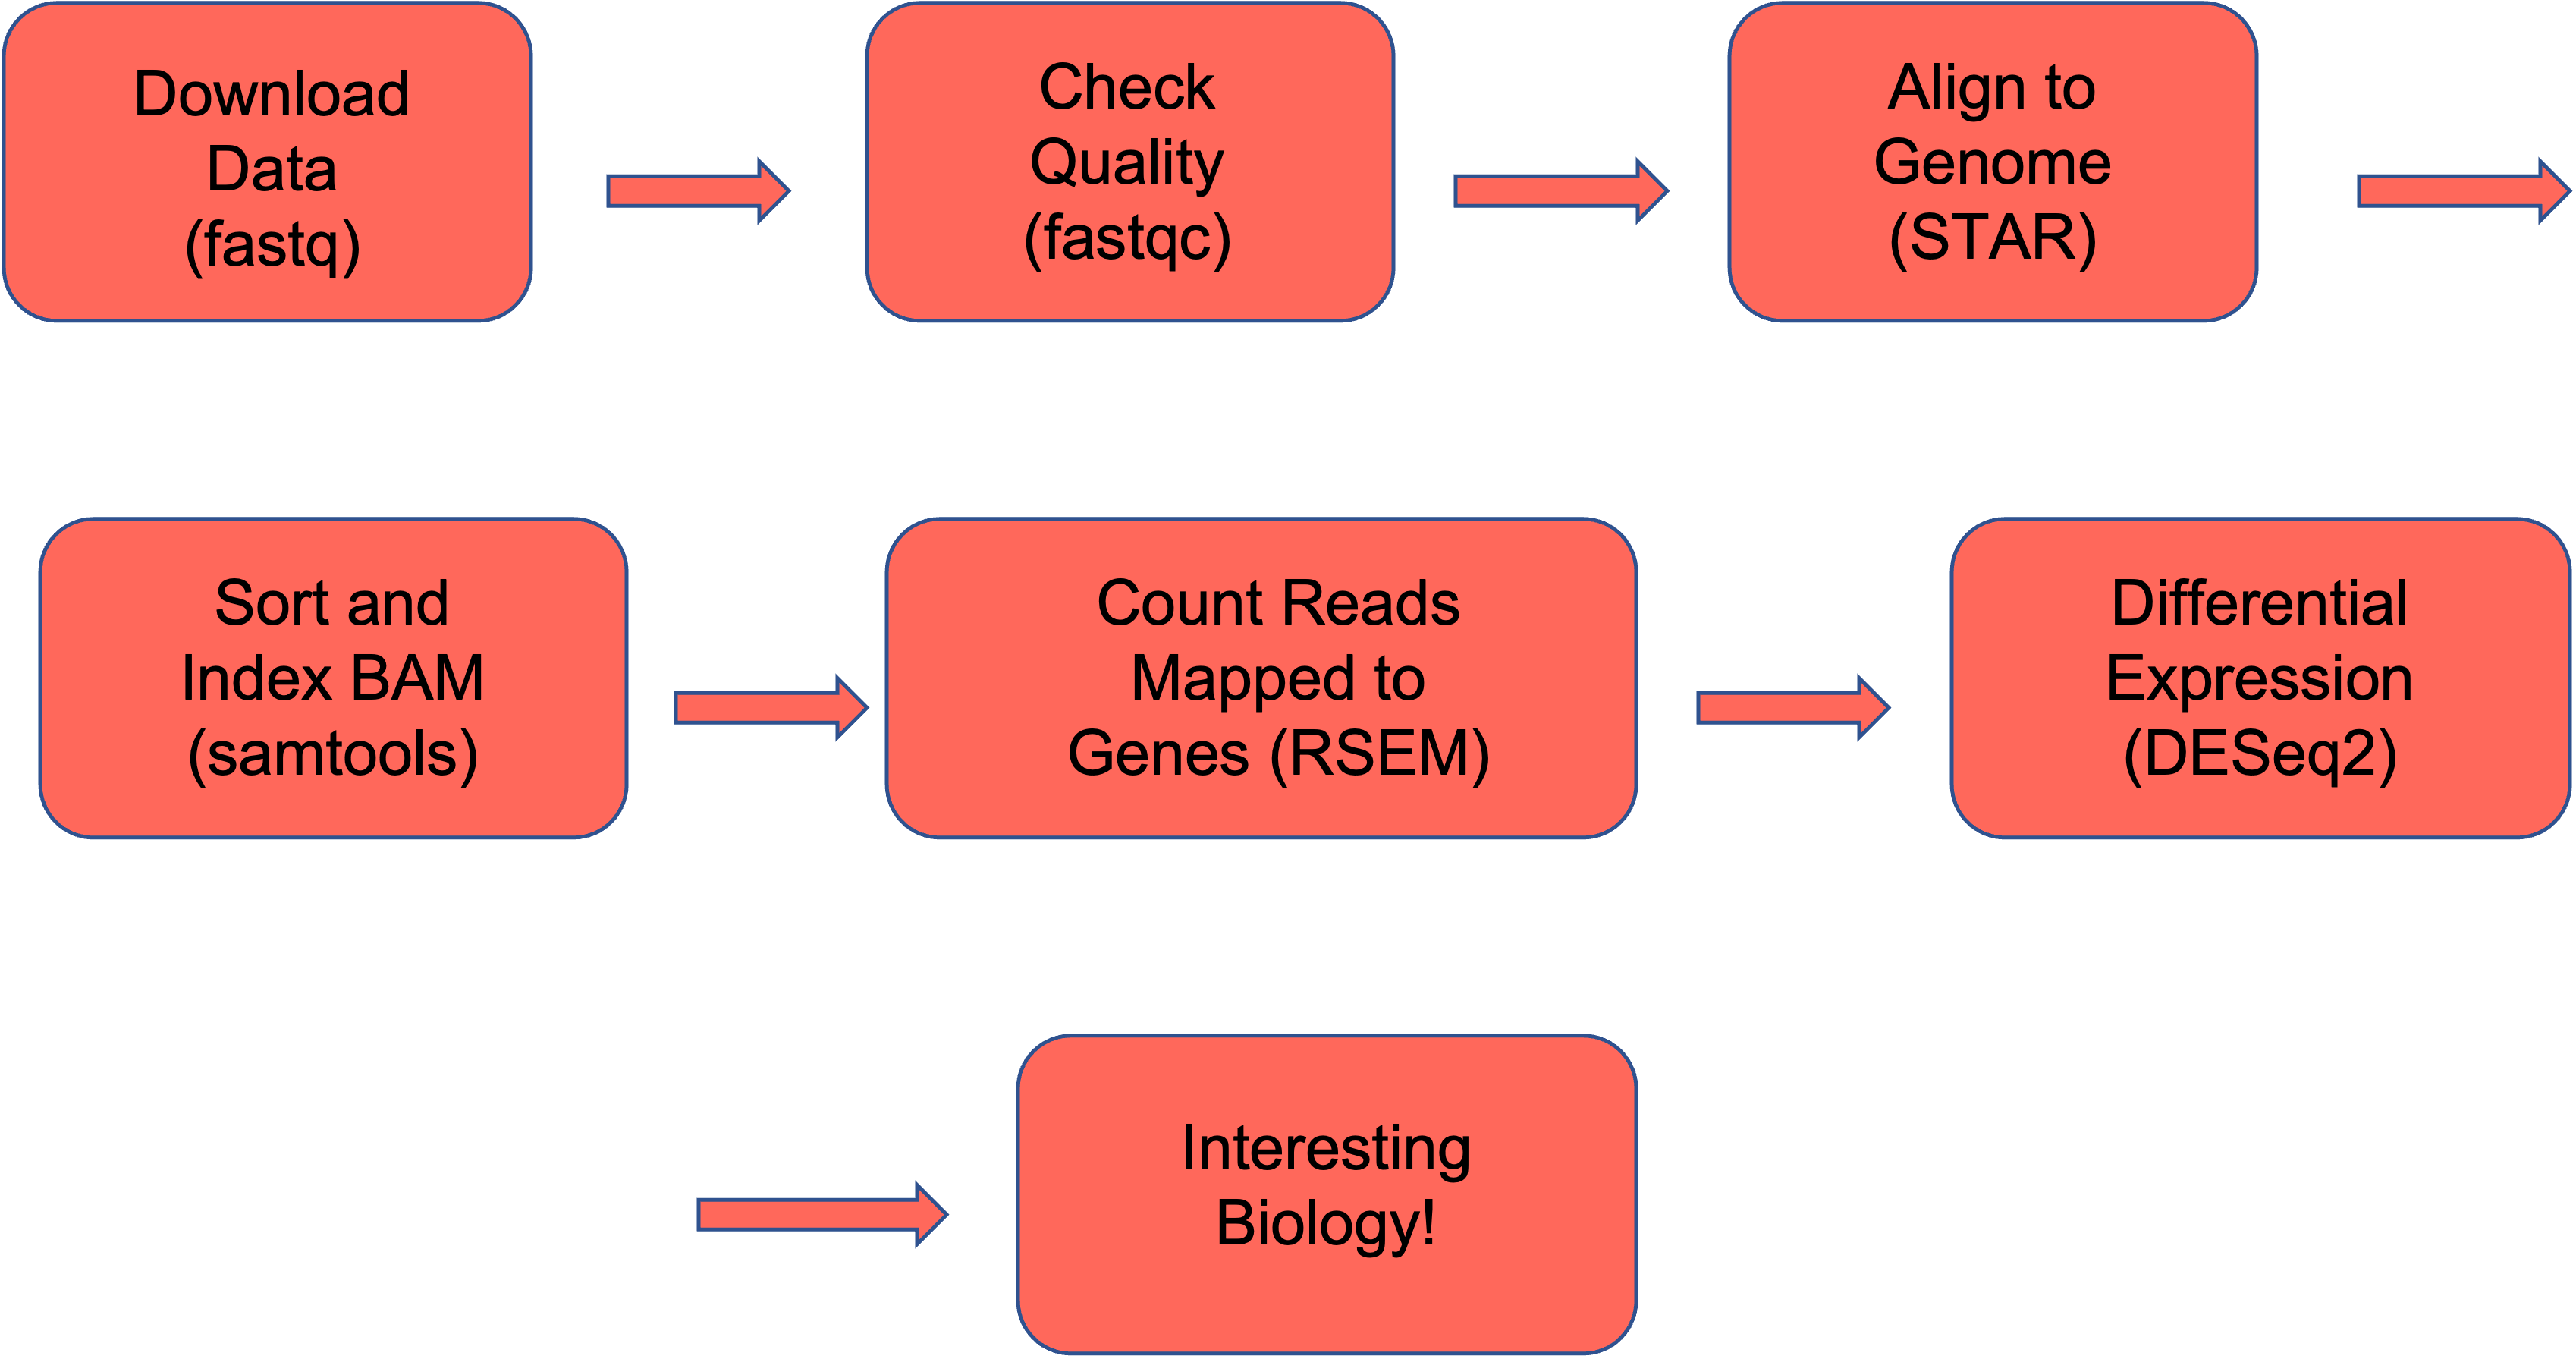
<center>Figure 1: Raw rna-seq processing steps</center>

Raw sequences for this tutorial were uploaded into the European Nucleotide Archive (ENA) under acession number <b>PRJNA523510</b>. To access the data, we will open the [ENA browser](https://www.ebi.ac.uk/ena/browser/view/) and search for the project under "Acession search box" (top right). Alternatively, the data can be accessed [here](https://www.ebi.ac.uk/ena/browser/view/PRJNA523510).

Once found, a list of all samples sequenced should be listed, and we can download the all the sample fastq by clicking on the "Download all generated FASTQ files: FTP" button. To analyze the data, we will use the terminal (Linux/Bash).

First, we will open the terminal and change paths to the directory where we stored the FastQ's. For example, if we stored the data in Downloads folder, we will access the data with this command:

Next, we will use Trimmomatic to trim sequencing data, remove read adapters and filter reads with low quality. It is important to know if we have single- or paired-end data. In this case, we are working for single-end data. For this, the command to execute Trimmomatic is:

With a cleaner version of the raw data, we can continue with alignment. Since our study was a series of human autopsies, we will use the latest human reference genome (hg38.v19) and annotation file. To do this, we will first download the corresponding references. We will need to download the the [human genome](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_39/gencode.v39.transcripts.fa.gz) and [genome annotations](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_39/gencode.v39.chr_patch_hapl_scaff.annotation.gtf.gz) from [GeneCode](https://www.gencodegenes.org/human/).

Once downloaded, we will need to index and prepare the files in a format needed for the alignment. To do so, we will first generate the genome with RSEM-STAR indexing. We will execute the following command:

This will create all necesary intermediate files to map the input FastQs to the human genome. And lastly, to quantify, we will use RSEM to get the result files. The command is as follows:

This step will create three files containing mapping information. We will use the <b>samplename.genes.results</b> files, which includes transcript quantification to genes (and transcripts) in the reference genome. These include the transcript ID, expected count, and transcript quantification metrics (TPM and FPKM). For more infomartion please refer to [this](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/).

## Load Packages

In this workshop, we will use the processed RNA-seq fastqs as described before, and use them for differential expression analysis. The data can be accessed at [github.com/ja-sandoval/med263group3final](https://github.com/ja-sandoval/med263group3final). You can click in Code, then Download Zip.

This will create a ZIP file with an rsem folder and all the data inside. We will use this for downstream analysis. Remember to run this Jupyter in the same directory where the rsem folder is at.

We will start by loading all the libraries needed for this tutorial.

In [114]:
# Read Input Data
library(tximportData)
library(tximport)
library(readr)

# DEG analyses and plots
library(DESeq2)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)
library(apeglm)
library(biomaRt)
library(grid)
library(futile.logger)
library(VennDiagram)

# GSEA analysis
library(msigdbr)
library(clusterProfiler)
library(org.Hs.eg.db)

ERROR: Error in library(msigdbr): there is no package called ‘msigdbr’


## Access Data Files

In the folder downloaded we have a sample metadata file. This will help us differentiate the patient conditions and sample names. We will first create a table with the metadata. A table with condition, sample name, replicate (number of sample) and gender for each sample will be created.

In [115]:
samples <- read.table("samples_reduced.txt", header = TRUE)
head(samples,11)

,pop,sampleID,replicate,gender
,<chr>,<chr>,<int>,<chr>
1,NAFLD,SRR8601526,1,Male
2,NAFLD,SRR8601527,2,Male
3,NAFLD,SRR8601528,3,Male
4,NAFLD,SRR8601529,4,Female
5,NAFLD,SRR8601530,5,Female
6,healthy,SRR8601558,2,Male
7,healthy,SRR8601559,3,Male
8,healthy,SRR8601561,5,Male
9,NASH,SRR8601547,7,Male


Next, we will create a sample-location list, so we can access de rsem data.

In [116]:
files <- file.path("rsem", paste0(samples$sample, ".genes.results"))
names(files) <- samples$sample
files

SRR8601526                      SRR8601527 
"rsem/SRR8601526.genes.results" "rsem/SRR8601527.genes.results" 
                     SRR8601528                      SRR8601529 
"rsem/SRR8601528.genes.results" "rsem/SRR8601529.genes.results" 
                     SRR8601530                      SRR8601558 
"rsem/SRR8601530.genes.results" "rsem/SRR8601558.genes.results" 
                     SRR8601559                      SRR8601561 
"rsem/SRR8601559.genes.results" "rsem/SRR8601561.genes.results" 
                     SRR8601547                      SRR8601548 
"rsem/SRR8601547.genes.results" "rsem/SRR8601548.genes.results" 
                     SRR8601549 
"rsem/SRR8601549.genes.results"

To access de data files, we will use tximport, to import the read count table for each of the samples processed. This command will create a table for each gene, with the number of transcripts that were counted for each of the samples in the analysis.

In [117]:
txi <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)
names(txi)
head(txi$counts)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 




[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

,SRR8601526,SRR8601527,SRR8601528,SRR8601529,SRR8601530,SRR8601558,SRR8601559,SRR8601561,SRR8601547,SRR8601548,SRR8601549
ENSG00000000003.15,1365.00,903.00,1318.00,1741.00,1583.0,1972.00,1883.00,1542.00,2266.00,1324.00,712.00
ENSG00000000005.6,2.00,2.00,0.00,0.00,1.0,1.00,8.00,1.00,1.00,0.00,0.00
ENSG00000000419.14,103.00,82.52,73.00,174.69,174.0,269.20,275.87,170.01,231.00,179.00,114.00
ENSG00000000457.14,60.13,61.95,143.24,88.27,151.1,179.63,207.85,143.72,144.09,96.58,182.72
ENSG00000000460.17,7.87,25.05,33.76,30.73,34.9,30.37,27.15,15.28,24.91,12.00,13.79
ENSG00000000938.13,23.00,21.00,41.00,25.00,19.0,35.00,63.00,47.00,47.00,19.00,14.00


## Differential Expression

In order to compare NASH vs healthy and NAFLD vs healthy samples, we first need to include the metadata information. To do this, we will create a sample table with these details

In [118]:
sampleTable <- data.frame(condition = samples$pop,replicate = samples$replicate) # Add metadata
sampleTable$condition <- relevel(factor(sampleTable$condition), ref = "healthy") # Use reference the healthy sample
rownames(sampleTable) <- colnames(txi$counts) # Name sampleID properly
head(sampleTable,11)

,condition,replicate
,<fct>,<int>
SRR8601526,NAFLD,1
SRR8601527,NAFLD,2
SRR8601528,NAFLD,3
SRR8601529,NAFLD,4
SRR8601530,NAFLD,5
SRR8601558,healthy,2
SRR8601559,healthy,3
SRR8601561,healthy,5
SRR8601547,NASH,7


The next step is to analyze the read count table. For this, we will use the newly created TXI table, containing the read count and the sample table to include the metadata information.

In [119]:
txi$length[txi$length <= 0] <- 1 # Non zero lengths
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition) # Use condition as the model comparison
dds <- DESeq(dds) # Analyze count data
vsd <- vst(dds, blind = FALSE) # Read count data normalized by size factor

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



<b>To visualize the correlation between each group's samples, we can take a look at a PCA plot. A PCA plot shows clusters of samples based on their similarity. </b>

We can then include the metadata and sample names to the plot, and a color-pattern based on distance (strong/low similarity)

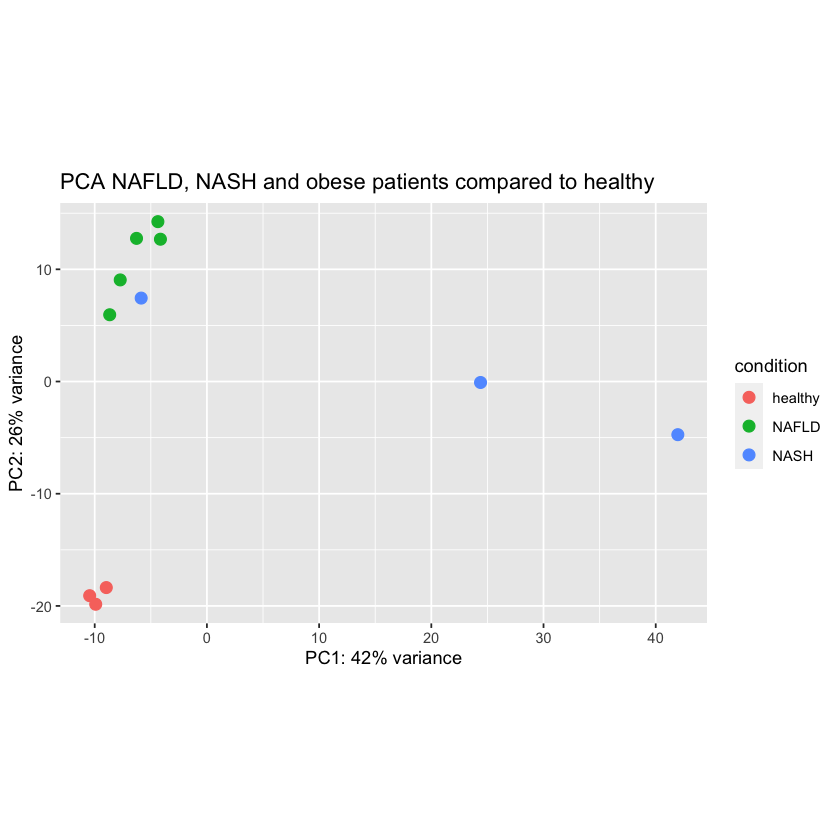

In [120]:
pcaData <- plotPCA(vsd, intgroup='condition', returnData = T) # Calculate similarity values
percentVar <- round(100 * attr(pcaData, "percentVar")) # Reformat values
ggplot(pcaData, aes(x = PC1, y = PC2, color = condition)) + geom_point(size =3) +
     xlab(paste0("PC1: ", percentVar[1], "% variance")) + ylab(paste0("PC2: ", percentVar[2], "% variance")) +
     coord_fixed() + guides(color = guide_legend(order=2), shape = guide_legend(order=1)) +
     ggtitle("PCA NAFLD, NASH and obese patients compared to healthy")

From the PCA graph, we can observe consistency with the heatmap results, as we observe a clear separation (cluster) of the healthy group -red- compared to the other groups.

Before contrasting expression patterns between the groups against healthy, we will start by normalizing using a Bayesian shrinkage estimator model, to account for effect sizes

In [121]:
resultsNames(dds)
res_maplot <- lfcShrink(dds, coef="condition_NAFLD_vs_healthy", type="apeglm") 

[1] "Intercept"                  "condition_NAFLD_vs_healthy"
[3] "condition_NASH_vs_healthy"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



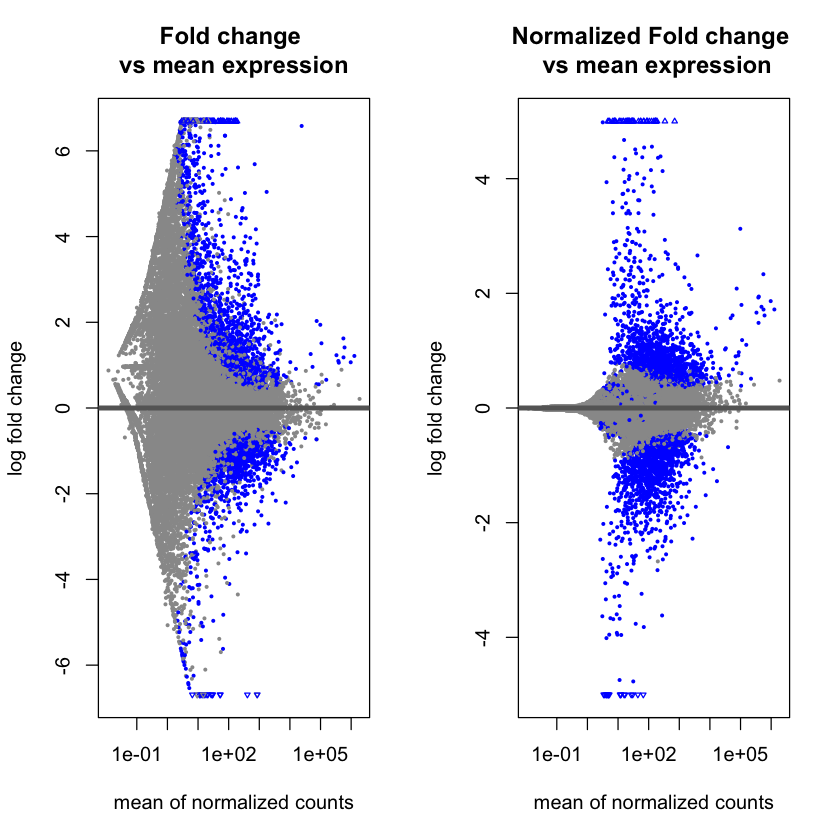

In [122]:
par(mfrow=c(1,2))
plotMA(dds, main='Fold change \nvs mean expression')
plotMA(res_maplot, ylim = c(-5, 5),main='Normalized Fold change \n vs mean expression')

Here it is important to normalize the fold change vs mean expression to remove technical variation and ensure that meaningful biological comparisons can be made

To extract gene expression changes from the NAFLD samples relative to healthy samples, we will use the following function:

In [123]:
res_NAFLD <- results(dds,name="condition_NAFLD_vs_healthy") # Extract fold change and statistics
head(res_NAFLD[order(res_NAFLD$padj),]) # Order by p-adj value

log2 fold change (MLE): condition NAFLD vs healthy 
Wald test p-value: condition NAFLD vs healthy 
DataFrame with 6 rows and 6 columns
                   baseMean log2FoldChange     lfcSE      stat      pvalue
                  <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000286140.1   339.376        5.59524  0.460362   12.1540 5.46320e-34
ENSG00000226608.3   337.676        2.97409  0.253408   11.7364 8.29820e-32
ENSG00000232573.1   706.901        5.69800  0.500600   11.3823 5.12054e-30
ENSG00000169245.6   143.420        3.43306  0.332425   10.3273 5.30312e-25
ENSG00000213886.4   146.244        3.84313  0.374223   10.2696 9.65728e-25
ENSG00000265401.1   164.785       24.26529  2.387936   10.1616 2.94157e-24
                         padj
                    <numeric>
ENSG00000286140.1 9.33879e-30
ENSG00000226608.3 7.09247e-28
ENSG00000232573.1 2.91769e-26
ENSG00000169245.6 2.26629e-21
ENSG00000213886.4 3.30163e-21
ENSG00000265401.1 8.38054e-21

It might be easier to look at the fold changes if we know the genes these corresponds to. For that, we will use [Gene Ensemble](https://uswest.ensembl.org/index.html) mapping library

In [124]:
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl")) # Look for library

Ensembl site unresponsive, trying useast mirror



In [125]:
# Keep genes with annotations
g_list <- getBM(filters= "ensembl_gene_id_version", attributes= c("ensembl_gene_id_version","hgnc_symbol"),
                values=rownames(res_NAFLD),mart= mart)
g_list_na <- g_list[g_list$hgnc_symbol != '',]
g_list_na <- g_list_na[!duplicated(g_list_na[,2]),]

# Match and keep genes with annotations
res_NAFLD_labeled <- subset(res_NAFLD, rownames(res_NAFLD) %in% g_list_na[,1])
rownames(res_NAFLD_labeled) <-  g_list_na$hgnc_symbol[ match(rownames(res_NAFLD_labeled), g_list_na$ensembl_gene_id_version)]

head(res_NAFLD_labeled[order(res_NAFLD_labeled$padj),]) # Order by p-adj value

log2 fold change (MLE): condition NAFLD vs healthy 
Wald test p-value: condition NAFLD vs healthy 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
FTLP3     337.676        2.97409  0.253408  11.73636 8.29820e-32 7.09247e-28
RPL3P4    706.901        5.69800  0.500600  11.38234 5.12054e-30 2.91769e-26
CXCL10    143.420        3.43306  0.332425  10.32730 5.30312e-25 2.26629e-21
UBD       146.244        3.84313  0.374223  10.26963 9.65728e-25 3.30163e-21
MT-ND4L 98312.270        3.17998  0.320836   9.91155 3.70856e-23 9.05630e-20
RPS23P8   201.751        4.45884  0.455872   9.78090 1.36002e-22 2.90603e-19

We repeat for the other groups

In [126]:
# NASH vs Healthy
res_NASH<-results(dds,name="condition_NASH_vs_healthy") # Extract fold change and statistics
head(res_NASH[order(res_NASH$padj),]) # Order by p-adj value

log2 fold change (MLE): condition NASH vs healthy 
Wald test p-value: condition NASH vs healthy 
DataFrame with 6 rows and 6 columns
                   baseMean log2FoldChange     lfcSE      stat      pvalue
                  <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000230629.2   201.751        5.61199  0.496344  11.30665 1.21644e-29
ENSG00000232573.1   706.901        5.68898  0.555000  10.25041 1.17841e-24
ENSG00000286140.1   339.376        5.01785  0.506725   9.90250 4.05987e-23
ENSG00000279364.1   124.425        7.30822  0.742691   9.84019 7.55649e-23
ENSG00000213886.4   146.244        3.98132  0.409465   9.72321 2.40086e-22
ENSG00000169245.6   143.420        3.22043  0.365966   8.79981 1.37044e-18
                         padj
                    <numeric>
ENSG00000230629.2 2.21124e-25
ENSG00000232573.1 1.07106e-20
ENSG00000286140.1 2.46001e-19
ENSG00000279364.1 3.43404e-19
ENSG00000213886.4 8.72858e-19
ENSG00000169245.6 4.15197e-15

In [127]:
# Keep genes with annotations
g_list <- getBM(filters= "ensembl_gene_id_version", attributes= c("ensembl_gene_id_version","hgnc_symbol"),
                values=rownames(res_NASH),mart= mart)
g_list_na <- g_list[g_list$hgnc_symbol != '',]
g_list_na <- g_list_na[!duplicated(g_list_na[,2]),]

# Match and keep genes with annotations
res_NASH_labeled <- subset(res_NASH, rownames(res_NASH) %in% g_list_na[,1])
rownames(res_NASH_labeled) <-  g_list_na$hgnc_symbol[ match(rownames(res_NASH_labeled), g_list_na$ensembl_gene_id_version)]

head(res_NASH_labeled[order(res_NASH_labeled$padj),]) # Order by p-adj value

log2 fold change (MLE): condition NASH vs healthy 
Wald test p-value: condition NASH vs healthy 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
RPS23P8   201.751        5.61199  0.496344  11.30665 1.21644e-29 2.21124e-25
RPL3P4    706.901        5.68898  0.555000  10.25041 1.17841e-24 1.07106e-20
UBD       146.244        3.98132  0.409465   9.72321 2.40086e-22 8.72858e-19
CXCL10    143.420        3.22043  0.365966   8.79981 1.37044e-18 4.15197e-15
FTLP3     337.676        2.42076  0.282230   8.57726 9.71635e-18 2.52320e-14
MARCO     370.748       -3.39401  0.434932  -7.80353 6.01975e-15 1.09427e-11

In [128]:
# Obese vs Healthy
#res_obese<-results(dds,name="condition_obese_vs_healthy") # Extract fold change and statistics
#head(res_obese[order(res_obese$padj),]) # Order by p-adj value

In [130]:
# Keep genes with annotations
#g_list <- getBM(filters= "ensembl_gene_id_version", attributes= c("ensembl_gene_id_version","hgnc_symbol"),
 #               values=rownames(res_obese),mart= mart)
#g_list_na <- g_list[g_list$hgnc_symbol != '',]
#g_list_na <- g_list_na[!duplicated(g_list_na[,2]),]

# Match and keep genes with annotations
#res_obese_labeled <- subset(res_obese, rownames(res_obese) %in% g_list_na[,1])
#rownames(res_obese_labeled) <-  g_list_na$hgnc_symbol[ match(rownames(res_obese_labeled), g_list_na$ensembl_gene_id_version)]

#head(res_obese_labeled[order(res_obese_labeled$padj),]) # Order by p-adj value

To compare these groups, we are now going to extract the upregalated genes, that have a fold change equal or greater than 2, and a p-adj threshold of 0.05.

In [131]:
sig_thresh = 2
padj_thresh = 0.05
up_nafld <- subset(res_NAFLD_labeled, padj < padj_thresh & log2FoldChange > sig_thresh)
up_nash <- subset(res_NASH_labeled, padj < padj_thresh & log2FoldChange > sig_thresh)
#up_obese <- subset(res_obese_labeled, padj < padj_thresh & log2FoldChange > sig_thresh)

We can order these by fold change value

In [132]:
up_nafld <- up_nafld[order(up_nafld$log2FoldChange, decreasing=T),]
up_nash <- up_nash[order(up_nash$log2FoldChange, decreasing=T),]
#up_obese <- up_obese[order(up_obese$log2FoldChange, decreasing=T),]
head(up_nafld)
head(up_nash)
#head(up_obese)

log2 fold change (MLE): condition NAFLD vs healthy 
Wald test p-value: condition NAFLD vs healthy 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
XIST        52.1595       21.75138   3.68813   5.89767 3.68674e-09 4.77433e-07
MT-TC      148.5078        9.51333   1.11485   8.53327 1.42274e-17 1.87079e-14
PWP2        18.5370        8.08006   2.21825   3.64253 2.69967e-04 4.32098e-03
RNA5-8SN3  170.7333        7.98310   1.17748   6.77984 1.20312e-11 2.98060e-09
RNA5-8SN1  170.7333        7.98310   1.17748   6.77984 1.20312e-11 2.98060e-09
RNA5-8SN2  170.7333        7.98310   1.17748   6.77984 1.20312e-11 2.98060e-09

log2 fold change (MLE): condition NASH vs healthy 
Wald test p-value: condition NASH vs healthy 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
EIF2S2P2    99.0211       10.79127   3.56368   3.02813 2.46076e-03 2.93515e-02
PWP2        18.5370        9.22583   2.40543   3.83542 1.25350e-04 3.77880e-03
ANKRD18A    17.1792        9.04192   2.57469   3.51184 4.45010e-04 9.33032e-03
PRELID1P6   16.9156        8.80004   2.28653   3.84864 1.18778e-04 3.61060e-03
RNA5-8SN3  170.7333        8.74261   1.26375   6.91798 4.58125e-12 2.92100e-09
RNA5-8SN1  170.7333        8.74261   1.26375   6.91798 4.58125e-12 2.92100e-09

Lastly, to evaluate similar genes in every condition, we can create Venn Diagrams and visualize the number of overlap genes.

In [133]:
groups <- list(NAFLD = rownames(up_nafld), NASH = rownames(up_nash), obese=c("1"))

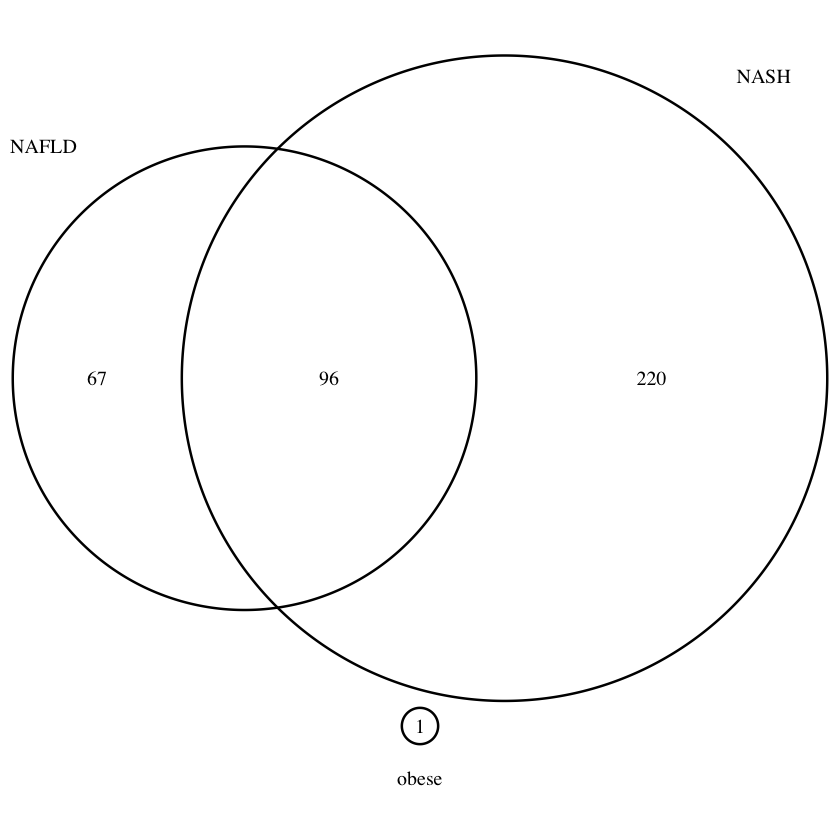

In [134]:
library(ggplot2)
grid.draw(venn.diagram(groups, filename = NULL))

Venn Diagram showing the number of Genes DE among healthy, nafld, and nash conditions.

## References

1. Nonalcoholic Fatty Liver Disease (NAFLD) & NASH | NIDDK.
2. Definition & Facts of NAFLD & NASH | NIDDK.
3. Rubinstein, Lavine, and Schwimmer. Hepatic, Cardiovascular, and Endocrine Outcomes of the Histological Subphenotypes of Nonalcoholic Fatty Liver Disease. Seminar Liver Disease (2008)